In [1]:
# Import Library
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel, UVit2DModel, UNet2DConditionModel
from matplotlib import pyplot as plt
import torchvision.transforms as transforms
from tqdm import tqdm
import numpy as np

device = "cuda"

/usr/local/lib/python3.10/dist-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
!pip install diffusers

100%|██████████| 169001437/169001437 [00:13<00:00, 12458991.43it/s]


Extracting cifar100/cifar-100-python.tar.gz to cifar100/


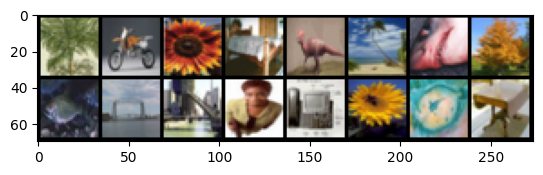

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
])
dataset = torchvision.datasets.CIFAR100(root="cifar100/", train = True, download = True, transform = transform)
Trainset = DataLoader(dataset, batch_size = 16, shuffle = True)
inputs,label = next(iter(Trainset))
img_grid = torchvision.utils.make_grid(inputs)
plt.imshow(img_grid.permute(1, 2, 0))
plt.show()

In [4]:
def addNoise(x, pi_x):
    return x*(1-pi_x).view(-1,1,1,1) + torch.rand_like(x)*pi_x.view(-1,1,1,1) # Balance between Noise and Input

def noiseVisualCheck(x, pi_x):
    fig,axs = plt.subplots(2,1,figsize=(12,7))
    axs[0].set_title("Input Image")
    img_grid = torchvision.utils.make_grid(x)
    axs[0].imshow(img_grid.permute(1, 2, 0))

    # Gradually Adding Noise
    weight = torch.linspace(0,1,x.shape[0])
    noisy_x = addNoise(x,weight)
    axs[1].set_title("Noise added data")
    img_grid = torchvision.utils.make_grid(noisy_x)
    axs[1].imshow(img_grid.permute(1, 2, 0))

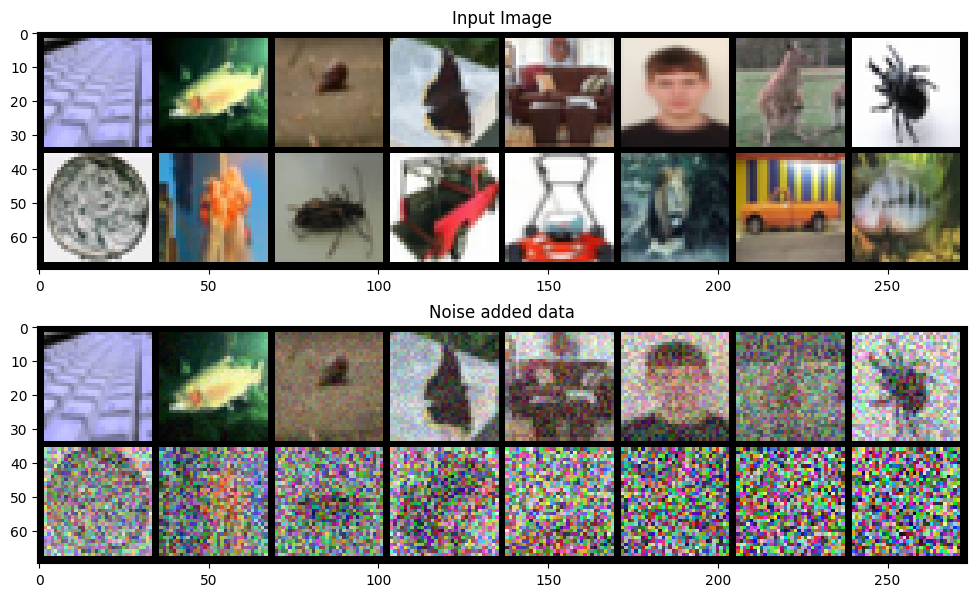

In [6]:
noiseVisualCheck(inputs, 0.8)

In [7]:
# Unet Implementation
# The structure follows the paper in 2015 biomedical image. https://arxiv.org/pdf/1505.04597.pdf
# But it is a simplified version, since we are using 3x32x32 cifar100 image dataset instead of 3x572x572
class BasicUNet(nn.Module):
    def __init__(self, in_channel, out_channel): # Numebr of Input image channels
        super().__init__()
        self.downSample_Layer = nn.Sequential(
            nn.Conv2d(in_channel, 32, kernel_size = 5, padding = 2), # Image height and weight does not change. Input channel -> 32
            nn.Conv2d(32, 64, kernel_size = 5, padding = 2),
            nn.Conv2d(64, 64, kernel_size = 5, padding = 2)
        )
        self.upSample_Layer = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size = 5, padding = 2), # Image height and weight does not change. Input channel -> 32
            nn.Conv2d(64, 32, kernel_size = 5, padding = 2),
            nn.Conv2d(32, out_channel, kernel_size = 5, padding = 2)
        )
        self.relu = nn.ReLU()
        self.downScale = nn.MaxPool2d(2) # 2x2 max pooling filter. 16x3x32x32 becomes 15+1 x15+1
        self.upScale = nn.Upsample(scale_factor = 2) # 16x3x32x32 becomes 16x3x64x64 under scale factor = 2

    def forward(self, x):
        layerResidual = []
        out = x
        for i,ly in enumerate(self.downSample_Layer):
            out = self.relu(ly(out))
            if i < 2:
                layerResidual.append(out)
                out = self.downScale(out)

        for i,ly in enumerate(self.upSample_Layer):
            if not i == 0:
                out = self.upScale(out)
                out += layerResidual.pop()
            out = self.relu(ly(out))
        return out


In [9]:
# training Process
trainLoader = DataLoader(dataset, batch_size = 128, shuffle = True)

model = BasicUNet(3,3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4)
loss = nn.MSELoss()
Loss = []

for epoch in tqdm(range(25)):
  for inputs,_ in trainLoader:
    inputs = inputs.to(device)
    noisy_inputs = addNoise(inputs, torch.rand(inputs.shape[0],dtype=torch.float).to(device))
    pred = model(noisy_inputs)
    loss_value = loss(pred,inputs)
    Loss.append(loss_value.item())
    optimizer.zero_grad()
    loss_value.backward()
    optimizer.step()

100%|██████████| 25/25 [03:22<00:00,  8.08s/it]


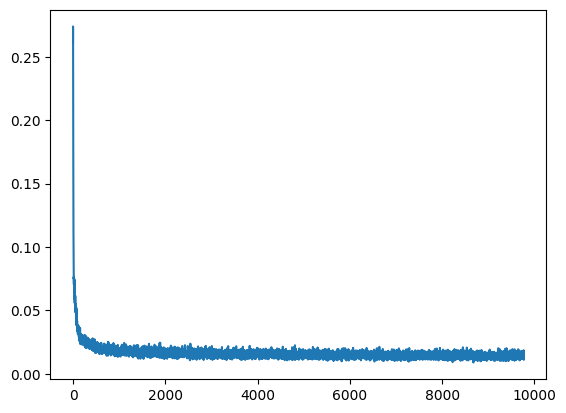

In [10]:
plt.plot(Loss)

In [11]:
def plot_images(input_images, noisy_images, predicted_images, num_images=8):
    """
    Plots a comparison of input, noisy, and predicted images in a 3-row grid.
    """
    fig, axs = plt.subplots(3, num_images, figsize=(24, 9))
    for i in range(num_images):
        img = input_images[i].detach().cpu().numpy().clip(0, 1)
        axs[0, i].imshow(np.transpose(img, (1, 2, 0)))
        axs[0, i].axis('off')
        axs[0, i].set_title('Input')

        noisy_img = noisy_images[i].detach().cpu().numpy().clip(0, 1)
        axs[1, i].imshow(np.transpose(noisy_img, (1, 2, 0)))
        axs[1, i].axis('off')
        axs[1, i].set_title('Noisy')

        pred_img = predicted_images[i].detach().cpu().numpy().clip(0, 1)
        axs[2, i].imshow(np.transpose(pred_img, (1, 2, 0)))
        axs[2, i].axis('off')
        axs[2, i].set_title('Predicted')

    plt.tight_layout()
    plt.show()


x,y = next(iter(trainLoader))
inputs = x.to(device)
noisy_inputs = addNoise(inputs, torch.rand(inputs.shape[0],dtype=torch.float).to(device))
preds = model(noisy_inputs.to(device)[:8])

plot_images(inputs[:8], noisy_inputs[:8], preds[:8])

NameError: name 'model' is not defined

In [ ]:
# Possible improvement
# 1. batch Normalization
# 2. optimization methods
# 3. Different convolutional kernel method?
# 4. Unet might be better for higher resolution image

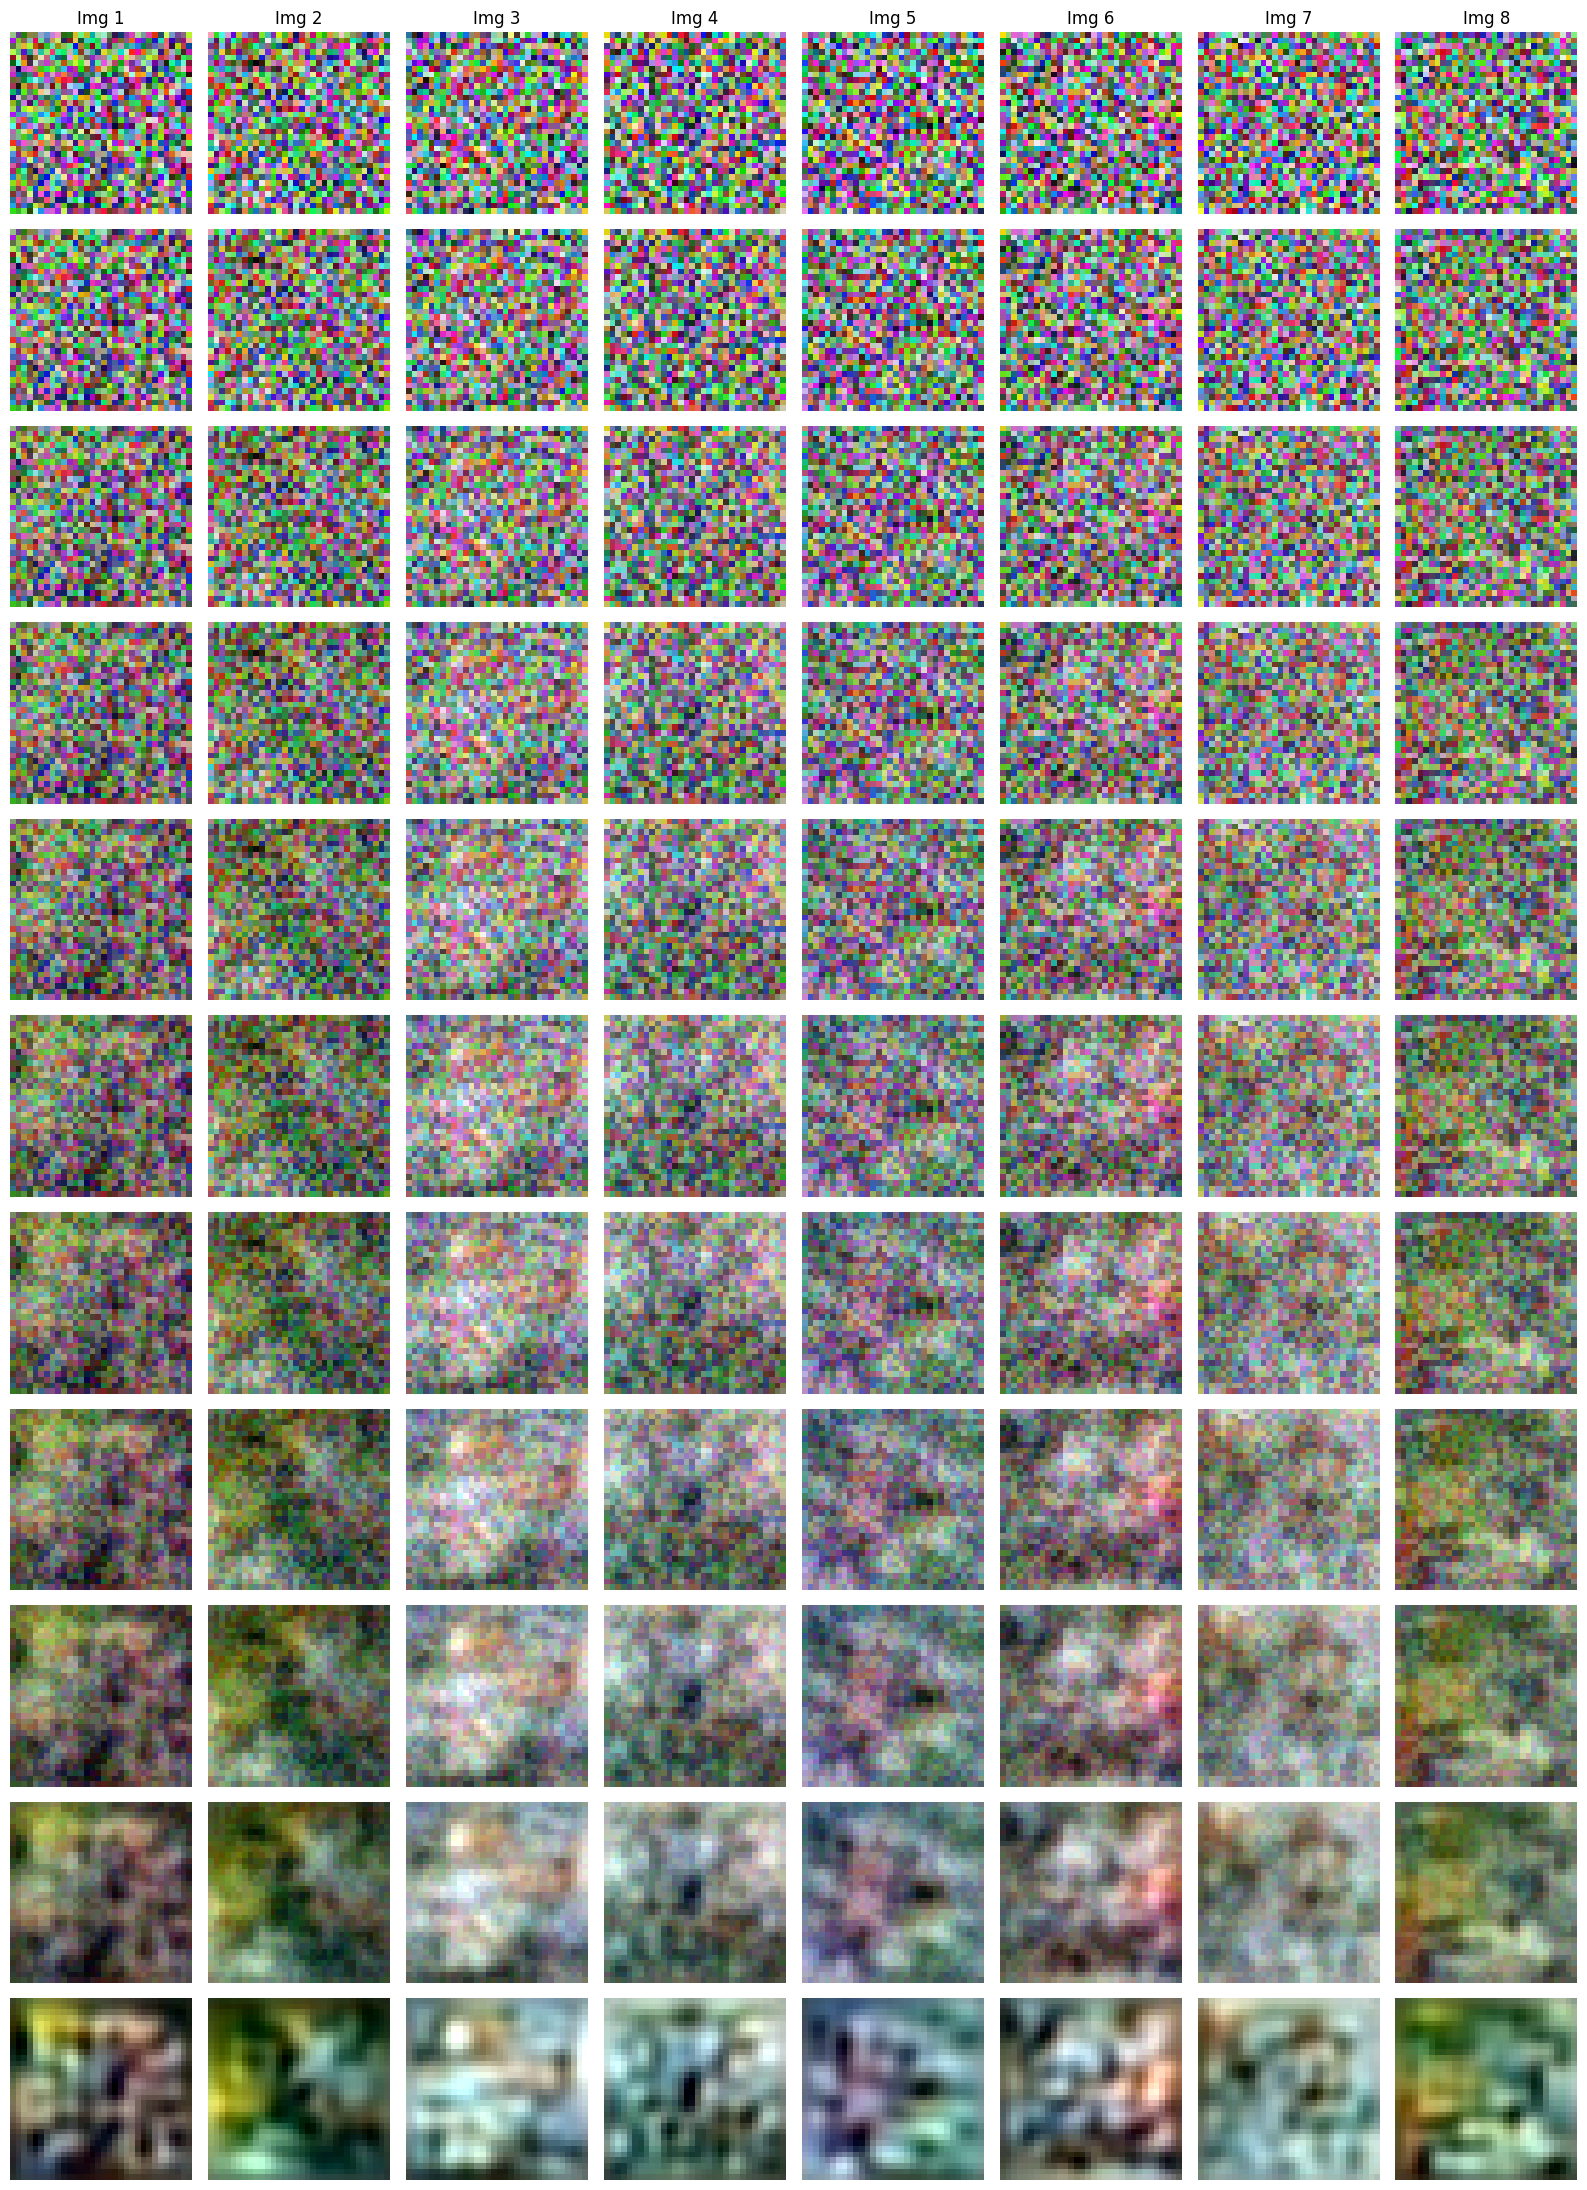

In [ ]:
# Diffusion Process?
# generated by ChatGPT
n_steps = 100
x = torch.rand(32, 3, 32, 32).to(device)
captured_images = []
capture_steps = [0, 9, 19] + list(range(29, n_steps, 10))

for i in range(n_steps):
    weight = torch.ones(x.shape[0]).to(device) * (1-(i/n_steps))
    with torch.no_grad():
        pred = model(x)
    mix_factor = 1/(n_steps-i)
    x = (1-mix_factor)*x + mix_factor*pred
    if i in capture_steps:
        captured_images.append(x[:8].cpu().clone())

def plot_denoising_steps(captured_images):
    n_steps = len(captured_images)
    n_images = len(captured_images[0])  # Assuming each step has the same number of images
    fig, axes = plt.subplots(n_steps, n_images, figsize=(n_images * 2, n_steps * 2))

    for step_index, step_images in enumerate(captured_images):
        for img_index, img_tensor in enumerate(step_images):
            img = img_tensor.numpy().transpose(1, 2, 0)
            img = img.clip(0, 1)  # Clip the image values to [0, 1] range
            ax = axes[step_index, img_index] if n_steps > 1 else axes[img_index]
            ax.imshow(img)
            ax.axis('off')
            if step_index == 0:
                ax.set_title(f'Img {img_index + 1}')

    plt.tight_layout()
    plt.show()

plot_denoising_steps(captured_images)



In [5]:
# How about Unet Model in diffusers?
# https://huggingface.co/docs/diffusers/en/api/models/uvit2d
model2 = UNet2DModel(
    sample_size=32,
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(32,64,64),
    down_block_types=("DownBlock2D", "AttnDownBlock2D", "AttnDownBlock2D"),
    up_block_types=("AttnUpBlock2D","AttnUpBlock2D", "UpBlock2D"),
)

In [6]:
# Difference of numer of parameter between two models
sum([p.numel() for p in model2.parameters()]) - sum([p.numel() for p in model.parameters()])

NameError: name 'model' is not defined

In [8]:
# training Process
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2"
)
trainLoader = DataLoader(dataset, batch_size = 128, shuffle = True)
model2 = model2.to(device)
optimizer = torch.optim.AdamW(model2.parameters(), lr = 4e-4)
loss = nn.MSELoss()
Loss = []

for epoch in tqdm(range(5)):
  for inputs,_ in trainLoader:
    noise = torch.randn(inputs.shape).to("cuda")
    inputs = inputs.to(device)
    timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (inputs.shape[0],), device="cuda").long()
    noisy_images = noise_scheduler.add_noise(inputs, noise, timesteps)
    pred = model2(noisy_images, timesteps, return_dict=False)[0]
    loss_value = loss(pred,inputs)
    Loss.append(loss_value.item())
    optimizer.zero_grad()
    loss_value.backward()
    optimizer.step()

100%|██████████| 5/5 [02:39<00:00, 31.89s/it]


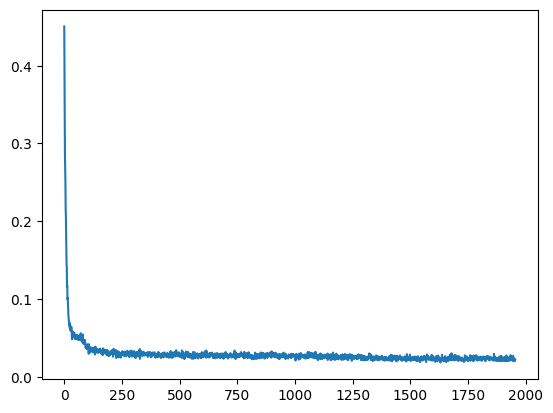

In [9]:
plt.plot(Loss)

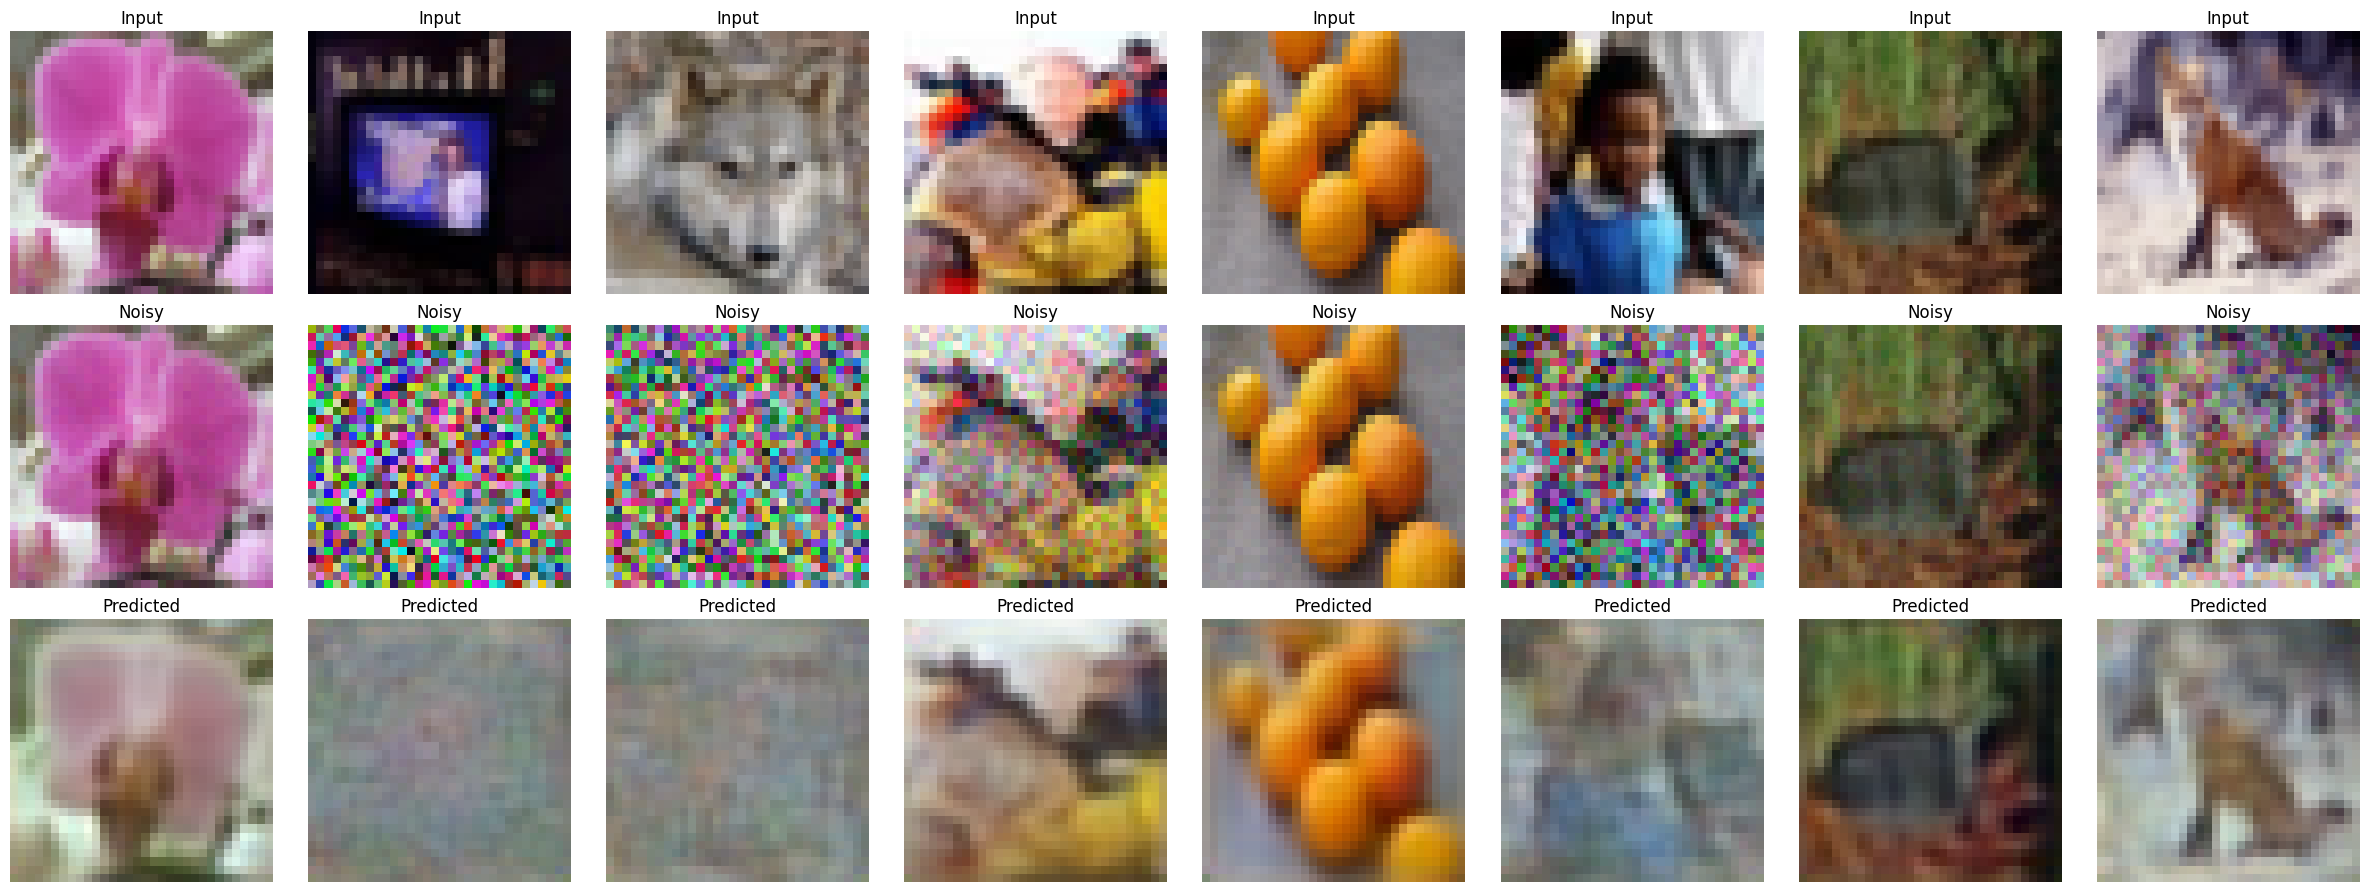

In [12]:
x,y = next(iter(trainLoader))
inputs = x.to(device)
noisy_inputs = addNoise(inputs, torch.rand(inputs.shape[0],dtype=torch.float).to(device))
preds = model2(noisy_inputs.to(device)[:8],13)[0]

plot_images(inputs[:8], noisy_inputs[:8], preds[:8])

In [2]:
! pip install -q kaggle

In [5]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"resssl","key":"a45838587164dde53b68e7a90399eccf"}'}

In [6]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [9]:
!kaggle datasets download -d diraizel/anime-images-dataset

100% 867M/868M [00:46<00:00, 23.2MB/s]
100% 868M/868M [00:46<00:00, 19.7MB/s]


In [10]:
import zipfile
zip_ref = zipfile.ZipFile('anime-images-dataset.zip', 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [2]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

In [19]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((128, 128))
    ])

In [20]:
dataset = datasets.ImageFolder(root='data/anime_images', transform=transform)

In [77]:
batch_size = 16
shuffle = True
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

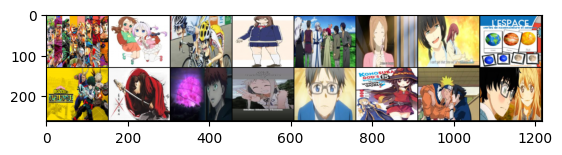

In [78]:
inputs,label = next(iter(dataloader))
img_grid = torchvision.utils.make_grid(torch.clip(inputs,0,1))
plt.imshow(img_grid.permute(1, 2, 0))
plt.show()

In [23]:
model3 = UNet2DModel(
    sample_size=(128,128),
    in_channels=3,
    out_channels=3,
    layers_per_block=2,
    block_out_channels=(32, 64, 64, 128),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)

In [25]:
# training Process
device = "cuda"
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2"
)
trainLoader = DataLoader(dataset, batch_size = 128, shuffle = True)
model3 = model3.to(device)
optimizer = torch.optim.AdamW(model3.parameters(), lr = 4e-4)
loss = nn.MSELoss()
Loss = []

for epoch in tqdm(range(20)):
  for inputs,_ in trainLoader:
    noise = torch.randn(inputs.shape).to("cuda")
    inputs = inputs.to(device)
    timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (inputs.shape[0],), device="cuda").long()
    noisy_images = noise_scheduler.add_noise(inputs, noise, timesteps)
    pred = model3(noisy_images, timesteps, return_dict=False)[0]
    loss_value = loss(pred,inputs)
    Loss.append(loss_value.item())
    optimizer.zero_grad()
    loss_value.backward()
    optimizer.step()

100%|██████████| 20/20 [2:39:58<00:00, 479.93s/it]


In [ ]:
plt.plot(Loss)

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
from PIL import Image


def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im


def make_grid(images, size=64):
    """Given a list of PIL images, stack them together into a line for easy viewing"""
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im

In [ ]:
sample = torch.randn(16, 3, 128, 128).to(device)

for i, t in enumerate(noise_scheduler.timesteps):

    # Get model pred
    with torch.no_grad():
        residual = model3(sample, t).sample

    # Update sample with step
    sample = noise_scheduler.step(residual, t, sample).prev_sample

show_images(sample)

In [14]:
import torch
import gc

# Assume `model` and `tensor` are variables you no longer need
del model3, dataset
gc.collect()  # Python's Garbage Collector

# PyTorch's way to release unused memory
torch.cuda.empty_cache()
